1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

C:\Users\rezvan\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


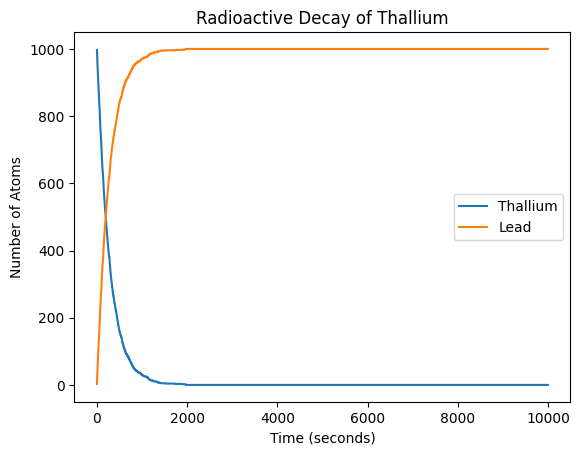

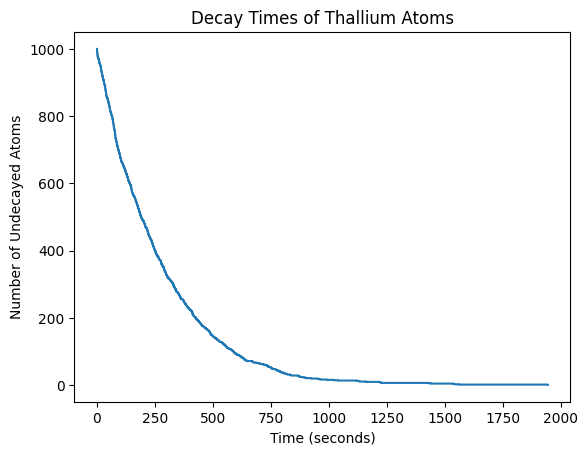

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
tau = 3.052 * 60  # half-life in seconds
initial_atoms = 1000
time_steps = 10000  # total time steps in seconds
decay_prob = lambda t: 1 - 2 ** (-t / tau)

# Part A: Time-step method
tl_atoms = initial_atoms
pb_atoms = 0
tl_count = []
pb_count = []
for t in range(time_steps):
    decayed = np.sum(np.random.random(tl_atoms) < decay_prob(1))
    tl_atoms -= decayed
    pb_atoms += decayed
    tl_count.append(tl_atoms)
    pb_count.append(pb_atoms)

# Plotting
plt.figure()
plt.plot(range(time_steps), tl_count, label='Thallium')
plt.plot(range(time_steps), pb_count, label='Lead')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Atoms')
plt.title('Radioactive Decay of Thallium')
plt.legend()
plt.show()

# Part B: Inverse transform method
def inverse_transform(tau, size=1):
    return -tau * np.log(1 - np.random.random(size)) / np.log(2)

decay_times = np.sort(inverse_transform(tau, initial_atoms))
undecayed = initial_atoms - np.arange(initial_atoms)
plt.figure()
plt.step(decay_times, undecayed)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Undecayed Atoms')
plt.title('Decay Times of Thallium Atoms')
plt.show()


2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

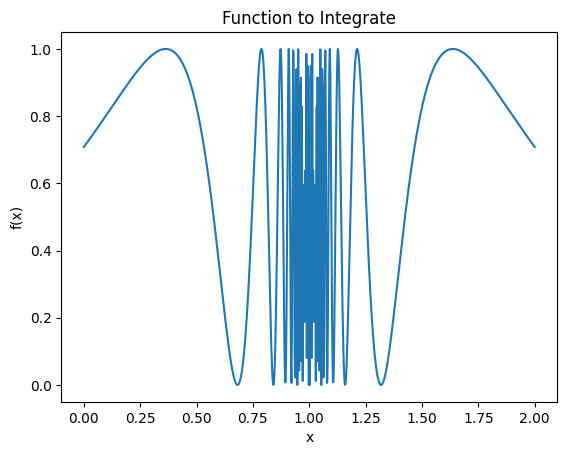

(1.3416, 1.3395082289527804)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to integrate
def f(x):
    return np.sin(1 / (1 - x))**2

# Plotting the function
x = np.linspace(0, 2, 1000)
plt.figure()
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function to Integrate')
plt.show()

# Monte Carlo Integration
N = 10000  # number of points

# Part A: Hit/Miss method
count = 0
for _ in range(N):
    x = 2 * np.random.random()
    y = np.random.random()
    if y < f(x):
        count += 1
integral_hit_miss = 2 * count / N

# Part B: Mean value method
integral_mean_value = 2 * np.mean(f(2 * np.random.random(N)))

# Output results
integral_hit_miss, integral_mean_value



In [12]:
import numpy as np

# Redefine the function to integrate
def f(x):
    return np.sin(1 / (1 - x))**2

# Implementing the Mean Value Method for Monte Carlo Integration
def mean_value_method(num_points, num_trials):
    integral_values = []
    for _ in range(num_trials):
        points = 2 * np.random.random(num_points)  # Random points between 0 and 2
        integral_values.append(2 * np.mean(f(points)))  # Multiply by the range (2)
    return np.mean(integral_values), np.std(integral_values)

# Number of points and trials for the mean value method
N = 10000
trials = 100

# Compute the integral and error using the mean value method
integral_mean, error_mean = mean_value_method(N, trials)

integral_mean, error_mean


(1.347417129466021, 0.006021383982698732)

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [3]:
import numpy as np

# Function to check if inside circle/sphere
def inside_circle(points):
    return np.sum(points**2, axis=1) <= 1

# 2D Circle
N = 10000
points_2d = np.random.random((N, 2)) * 2 - 1  # points in [-1, 1] range
area_circle = np.sum(inside_circle(points_2d)) / N * 4  # 4 is the area of the square

# 10D Sphere
points_10d = np.random.random((N, 10)) * 2 - 1
volume_sphere = np.sum(inside_circle(points_10d)) / N * 2**10

# Output results
area_circle, volume_sphere


(3.1472, 2.3552)

4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [10]:
import numpy as np

# Function to integrate
def function(x):
    return x**(-0.5) / (np.exp(x) + 1)

# Normalized weight function
def weight(x):
    return 1 / (2 * np.sqrt(x))  # Normalization factor is 2

# Inverse CDF for the normalized weight function
def inverse_cdf(y):
    return y**2

# Importance sampling with normalization
N = 10000
uniform_samples = np.random.random(N)
samples = inverse_cdf(uniform_samples)
integral = np.mean(function(samples) / weight(samples))  # Multiply by the normalization factor

integral


0.8383864974158776